1. Naive bayse (Then check out misclassified using plot)

2. model stacking (then visulaize the effect of model stack)
    3. NN first overfit with small dataset
    4. First by simple models 
    5. then nfolds

3. try out to learn misclassified
 


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df_train = pd.read_csv('F:/Titanic/data/train.csv')

In [4]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
def replace_age_fraction(df_train):
    # Age values that are less than value are multiplied by 100 to convert in Ten Placesimport h2o
    df_train.loc[df_train['Age']<1,'Age'] = df_train.loc[df_train['Age']<1,'Age']*100
    print len(df_train.loc[df_train['Age']<1,'Age'])


In [6]:
def replace_na_to_mode(df_train):
    for i in df_train.columns:
    
        if(i in ['PassengerId','Name']):
            pass
        else:
            print i
            df_train[i]= df_train[i].fillna(df_train[i].mode()[0]) # fill na by mode Values

In [7]:
replace_age_fraction(df_train)
replace_na_to_mode(df_train)

0
Survived
Pclass
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


In [8]:
# PassengerID and Name are unique values, that does not exhibit unique pattern in this case; so, we will remove these
# two columns from the dataframe
del(df_train['PassengerId'])
del(df_train['Name'])

In [9]:
import h2o
h2o.init(max_mem_size='6g')

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.121-b13, mixed mode)
  Starting server from C:\Users\hamza\Anaconda3\envs\gl-env\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: c:\users\hamza\appdata\local\temp\tmp0gmzb3
  JVM stdout: c:\users\hamza\appdata\local\temp\tmp0gmzb3\h2o_hamza_started_from_python.out
  JVM stderr: c:\users\hamza\appdata\local\temp\tmp0gmzb3\h2o_hamza_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,07 secs
H2O cluster version:,3.10.3.4
H2O cluster version age:,1 month and 11 days
H2O cluster name:,H2O_from_python_hamza_mb2x18
H2O cluster total nodes:,1
H2O cluster free memory:,5.333 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [10]:
# upload data to h2o frame
hdf= h2o.H2OFrame(df_train)

# factor the class label
hdf['Survived']= hdf['Survived'].asfactor()

# create train and validation datasets for model learining with 70 and 30 percent ratio
hdf_train, hdf_validate = hdf.split_frame(ratios=[0.70], seed=10)


# create input and response column names
response = 'Survived'
input_name= hdf.col_names
input_name.remove(response)
print input_name

Parse progress: |█████████████████████████████████████████████████████████| 100%
[u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked']


In [11]:
# h2o.shutdown()

In [12]:
def model_performance(model):
    print 'Train accuracy:', model.auc(train=True)
    print 'valid accuracy:', model.auc(valid=True)

    roc_valid = model.roc(valid=True)
    roc_train= model.roc()

    plt.plot(roc_valid[0],roc_valid[1])
    plt.plot(roc_train[0],roc_train[1])
    plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))
    
    plt.title('ROC Curve')
    plt.legend(['Valid','Train'])
    plt.show()



## Base Model Learning

In [13]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [14]:
my_nb =H2ONaiveBayesEstimator(seed =1)
my_nb.train(x = input_name, y = 'Survived', training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


Train accuracy: 0.814524291498
valid accuracy: 0.806658942955


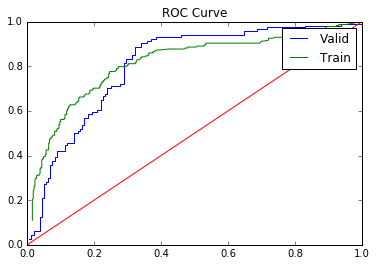

In [15]:
model_performance(my_nb)

In [16]:
# Train a GBM
my_gbm = H2OGradientBoostingEstimator(ntrees=200,
                                      max_depth=5,
                                      min_rows=3,
                                      learn_rate=0.01,
                                      seed=1,
                                     model_id="my_gbm",)
my_gbm.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.951658794422
valid accuracy: 0.894571333995


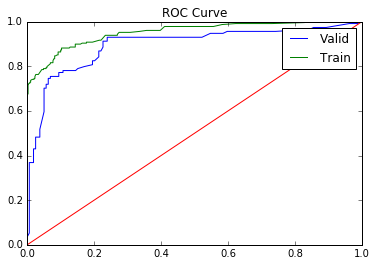

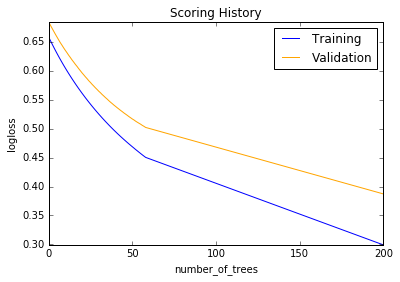

In [17]:
model_performance(my_gbm)
my_gbm.plot()

In [22]:
my_dt = H2ORandomForestEstimator(ntrees=1,
                                 max_depth = 25,
                                 min_rows=10,
                                 binomial_double_trees = True,
                                 sample_rate = 0.65,
                                 seed=1)
my_dt.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

drf Model Build progress: |███████████████████████████████████████████████| 100%



Train accuracy: 0.871620160069
valid accuracy: 0.808865717754


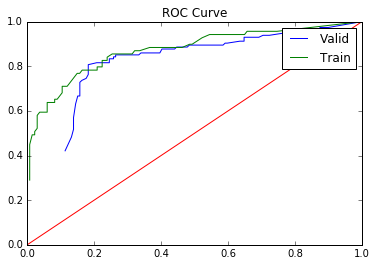

In [24]:
model_performance(my_dt)
# my_rf.plot()

In [35]:
my_rf = H2ORandomForestEstimator(ntrees=20,
                                 max_depth = 30,
                                 min_rows=10,
                                 binomial_double_trees = True,
                                 sample_rate = 0.30,
                                 seed=1)
my_rf.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

drf Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.858968735942
valid accuracy: 0.869717532826


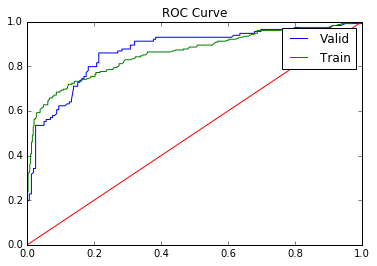

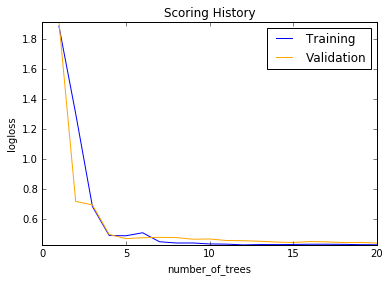

In [36]:
model_performance(my_rf)
my_rf.plot()

### K-Fold Models

In [42]:
# Train and cross-validate a GBM
nfold_gbm = H2OGradientBoostingEstimator(ntrees=150,
                                      max_depth=5,
                                      min_rows=3,
                                      learn_rate=0.01,
                                      nfolds=7,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1,
#                                       overwrite_with_best_model = False,
                                     model_id="my_gbm",)
nfold_gbm.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)


gbm Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.943460413855
valid accuracy: 0.894047224981


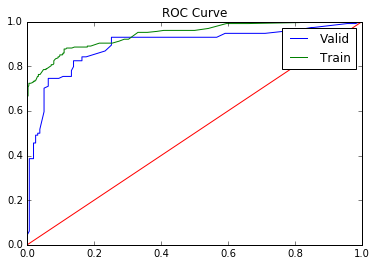

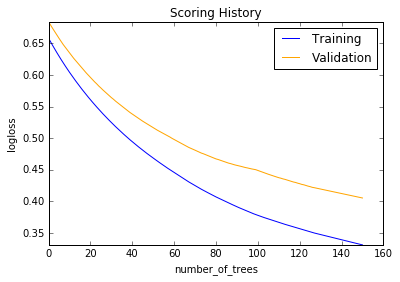

In [43]:
model_performance(nfold_gbm)
nfold_gbm.plot()

In [51]:
# Train and cross-validate a NB
nfold_nb =H2ONaiveBayesEstimator(seed =1,
                              nfolds=15,
                              fold_assignment="Modulo",
                              keep_cross_validation_predictions=True)
nfold_nb.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


Train accuracy: 0.814524291498
valid accuracy: 0.806658942955


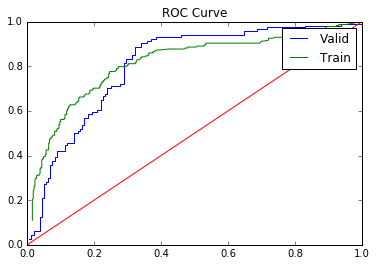

In [52]:
model_performance(nfold_nb)
# nfold_nb.plot()

In [55]:
# Train and cross-validate a DL
nfold_dl = H2ODeepLearningEstimator(seed =1,  
                              hidden=[200,200],
                              epochs =100,
                              l2= 1e-5,
#                               l1=1e-2,
                              activation = 'MaxoutWithDropout',
                              distribution = 'AUTO',
                              nfolds=5,
                              fold_assignment="Modulo",
                              keep_cross_validation_predictions=True)
nfold_dl.train(x =input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


Train accuracy: 0.894236392263
valid accuracy: 0.891812865497


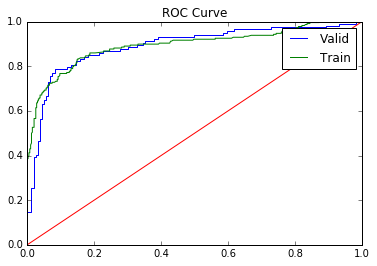

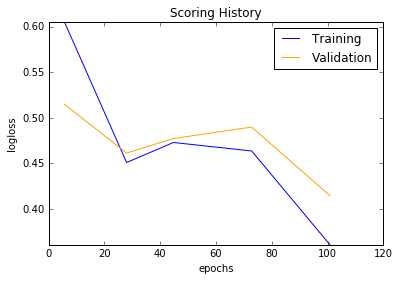

In [56]:
model_performance(nfold_dl)
nfold_dl.plot()

## Super Model Learning

In [37]:
def get_level_one_data(base_model=[], response = 'Y', data = hdf_train, remove_response = False): 
    level_one_data= data[response]
    
    for i in base_model:
        level_one_data = level_one_data.cbind(i.predict(data)['predict'])
    if(remove_response == False):
        return level_one_data
    elif(remove_response == True):
        level_one_data = level_one_data.drop(response)
        return level_one_data

In [38]:
def ensemble_train(level_one_data, base_model=[], response = 'Y'):
    
    x = level_one_data.col_names
    x.remove(response)

    level_one_data_test, level_one_data_valid = level_one_data.split_frame([0.75])

    meta_learner.train(x = x, y = response, training_frame = level_one_data_test,
                       validation_frame=level_one_data_valid)


In [88]:
meta_learner = H2ODeepLearningEstimator(seed =10,
                                        hidden =[200,200,200,200],
                                        epochs =70,
                                        activation = 'Maxout',
                                        distribution = 'AUTO',
                                        nfolds=20,
                                        l2=1e-25, 
                                        model_id='dl10',
                                        overwrite_with_best_model = False,
                                        rate = 0.001
                                       )

In [ ]:
base_models=[my_gbm, my_dt, my_nb, my_rf, nfold_gbm, nfold_nb, nfold_dl]
ensemble_train(level_one_data=get_level_one_data(base_model=base_models, response= response),
                   base_model=base_models,response=response)

gbm prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
naivebayes prediction progress: |█████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
naivebayes prediction progress: |█████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████

In [ ]:
model_performance(meta_learner)
meta_learner.plot()

In [79]:
def get_dataframe(model, data, class_col = 'Survived', predict_col = 'predict'):
    tmp_df = model.predict(data)['predict']
    tmp_df = tmp_df.cbind(data['Survived'])
    pand_df = tmp_df.as_data_frame()
    pand_df['range'] = range(0,len(data))
    return pand_df

In [80]:
# x takes the id's values (x-axis)
# y1 corresponds to Target values
# y2 corresponds to Predicted values

def plot_misclassified(x, y1,y2):
    plt.figure(figsize=(15,4))
    plt.scatter(x, y1, s=100, c='r')
    plt.scatter(x, y2, s=30, c='b', alpha=0.5)
    plt.show()

In [81]:
# This function takes dataframe with id's, predict and target values
def plot_misclassified_dynamically(data, start, end, step, x_col, y1_col, y2_col):
    
    r = list(np.arange(start, end, step))
    r = list(r)
    r.append(end)

    for i in range(0,len(r)-1):
        print 'Range of values from: ', r[i], ' to: ', r[i+1]
        X = data.ix[r[i]:r[i+1], x_col]
        Y1 = data.ix[r[i]:r[i+1], y1_col]
        Y2 = data.ix[r[i]:r[i+1], y2_col]

        plot_misclassified(x=X, y1=Y1, y2=Y2)

In [82]:
# This function will take dataframe and number of values each dataframe contains and will draw missclassified charts
def init_dynamic_plot(data, Step = 150, X_col = 'range', Y1_col = 'predict', Y2_col = 'Survived'):
    X = data.range
    Y1 = data.predict
    Y2 = data.Survived

    Start = min(data[X_col])
    End = max(data[X_col])
    
    plot_misclassified_dynamically(data=pred_df, start=Start, end=End, step= Step, x_col=X_col, y1_col=Y1_col, y2_col=Y2_col)


			==========================Naive Bayse Classification==========================
naivebayes prediction progress: |█████████████████████████████████████████| 100%
Range of values from:  0  to:  150


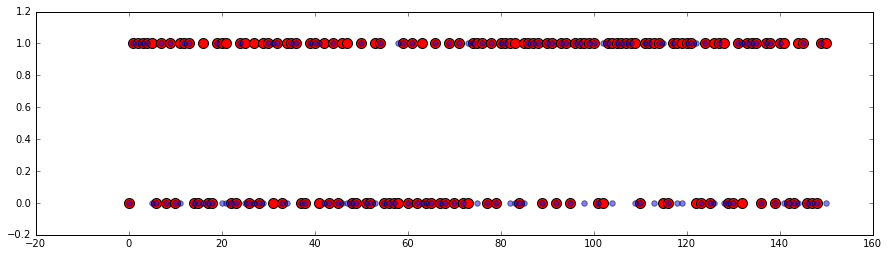

Range of values from:  150  to:  272


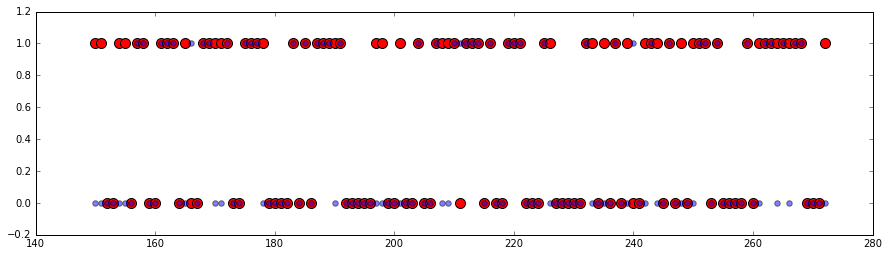

In [83]:
print ('\t\t\t==========================Naive Bayse Classification==========================')
pred_df = get_dataframe(my_nb,hdf_validate)
init_dynamic_plot(pred_df,150)

			==========================Gradient Boosting Machine Classification==========================
gbm prediction progress: |████████████████████████████████████████████████| 100%
Range of values from:  0  to:  150


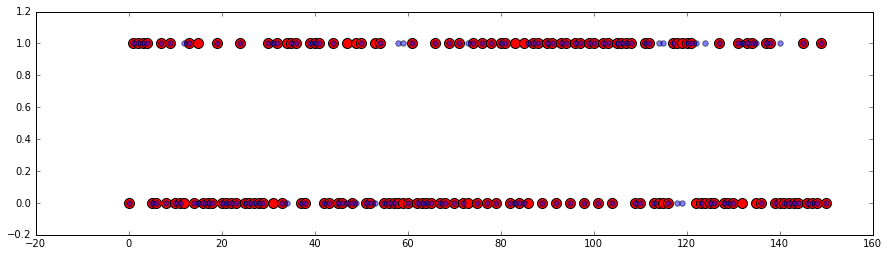

Range of values from:  150  to:  272


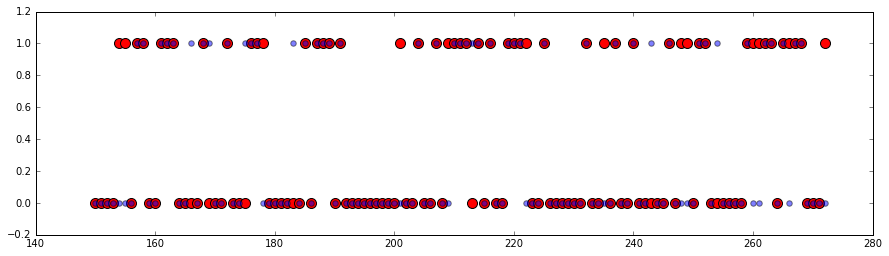

In [84]:
print ('\t\t\t==========================Gradient Boosting Machine Classification==========================')
pred_df = get_dataframe(my_gbm,hdf_validate)
init_dynamic_plot(pred_df,150)

			==========================Decision Tree Classification==========================
drf prediction progress: |████████████████████████████████████████████████| 100%
Range of values from:  0  to:  150


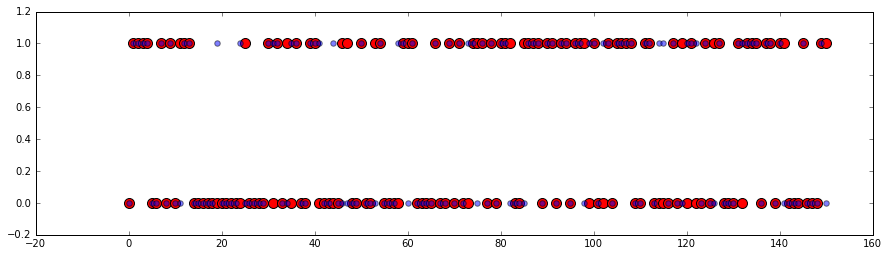

Range of values from:  150  to:  272


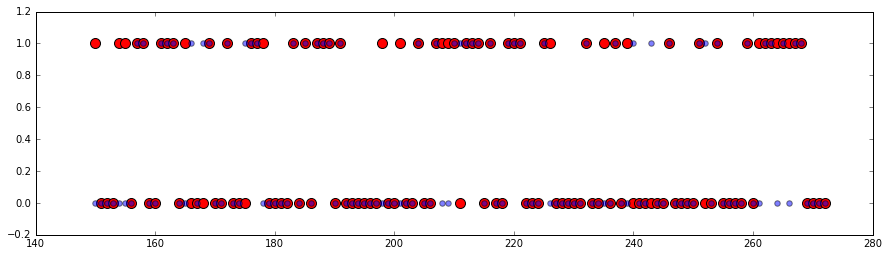

In [85]:
print ('\t\t\t==========================Decision Tree Classification==========================')
pred_df = get_dataframe(my_dt,hdf_validate)
init_dynamic_plot(pred_df,150)

In [86]:
base_models=[my_gbm, my_dt, my_nb, my_rf, nfold_gbm, nfold_nb, nfold_dl]

base_model_test_prediction = my_gbm.predict(hdf_validate)['predict']
base_model_test_prediction = base_model_test_prediction.cbind(my_dt.predict(hdf_validate)['predict'])
base_model_test_prediction = base_model_test_prediction.cbind(my_nb.predict(hdf_validate)['predict'])
base_model_test_prediction = base_model_test_prediction.cbind(my_rf.predict(hdf_validate)['predict'])
base_model_test_prediction = base_model_test_prediction.cbind(nfold_gbm.predict(hdf_validate)['predict'])
base_model_test_prediction = base_model_test_prediction.cbind(nfold_nb.predict(hdf_validate)['predict'])
base_model_test_prediction = base_model_test_prediction.cbind(nfold_dl.predict(hdf_validate)['predict'])


gbm prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
naivebayes prediction progress: |█████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
naivebayes prediction progress: |█████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


			==========================Deep Learning Classification(Meta Learner)==========================
deeplearning prediction progress: |███████████████████████████████████████| 100%
Range of values from:  0  to:  150


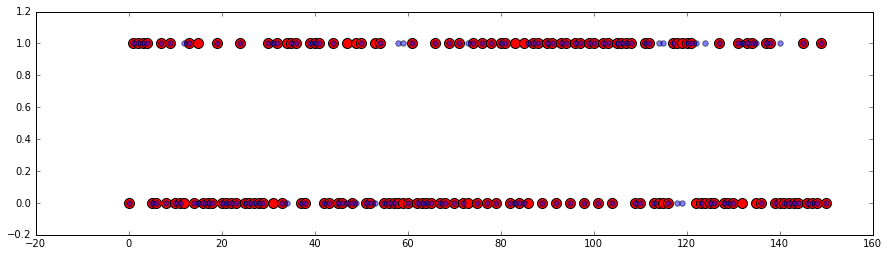

Range of values from:  150  to:  272


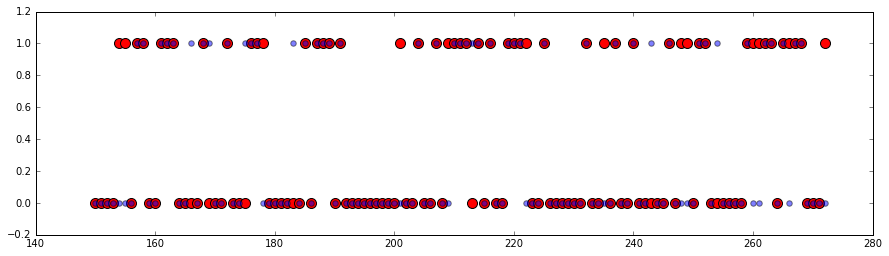

In [87]:
print ('\t\t\t==========================Deep Learning Classification(Meta Learner)==========================')
pred_df = meta_learner.predict(base_model_test_prediction)['predict']
pred_df = pred_df.cbind(hdf_validate['Survived'])
pred_df = pred_df.as_data_frame()
pred_df['range'] = range(0,len(hdf_validate))

init_dynamic_plot(pred_df,150)